In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image


In [3]:
csv_path = '/content/HAM10000_metadata.csv'
df = pd.read_csv(csv_path)

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


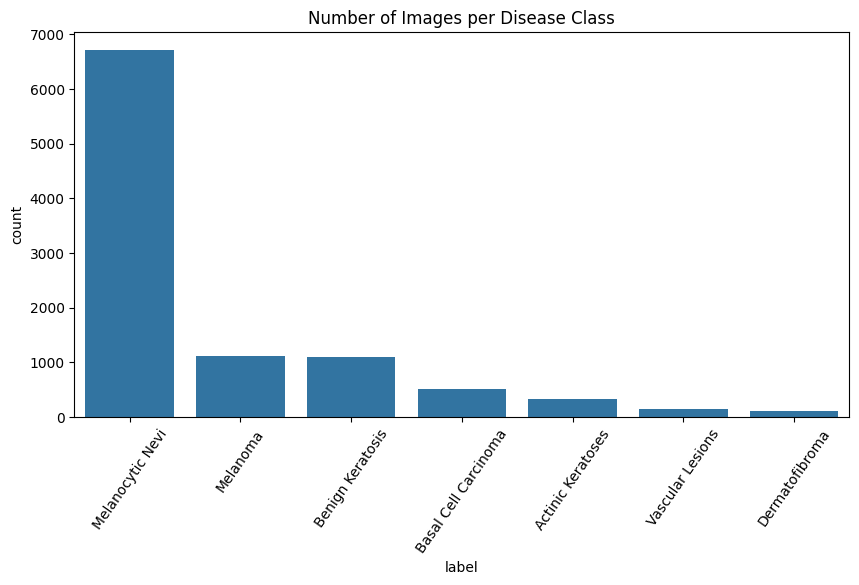

In [5]:
label_map = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'bkl': 'Benign Keratosis',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

df['label'] = df['dx'].map(label_map)

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Number of Images per Disease Class')
plt.xticks(rotation=55)
plt.show()


In [6]:

# Step 1: Remove multiple .jpg layers
df['image_id'] = df['image_id'].str.replace('.jpg', '', regex=False)

# Step 2: single clean .jpg
df['image_id'] = df['image_id'] + '.jpg'

print(df[['image_id', 'label']].head())


           image_id             label
0  ISIC_0027419.jpg  Benign Keratosis
1  ISIC_0025030.jpg  Benign Keratosis
2  ISIC_0026769.jpg  Benign Keratosis
3  ISIC_0025661.jpg  Benign Keratosis
4  ISIC_0031633.jpg  Benign Keratosis


In [7]:
from google.colab import drive
drive.mount('/content/drive')

image_folder = '/content/drive/MyDrive/AI Project images/HAM10000_raw_zips'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import glob

jpg_files = glob.glob('/content/drive/MyDrive/HAM10000_images/*.jpg')
print(f"Found {len(jpg_files)} JPG images.")
print(jpg_files[:5])  # Print first 5 filenames


Found 10015 JPG images.
['/content/drive/MyDrive/HAM10000_images/ISIC_0033347.jpg', '/content/drive/MyDrive/HAM10000_images/ISIC_0033348.jpg', '/content/drive/MyDrive/HAM10000_images/ISIC_0033350.jpg', '/content/drive/MyDrive/HAM10000_images/ISIC_0033349.jpg', '/content/drive/MyDrive/HAM10000_images/ISIC_0033351.jpg']


In [9]:
#  Fix image_id column to remove multiple .jpgs
df['image_id'] = df['image_id'].str.extract(r'(ISIC_\d{7})')[0] + '.jpg'

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,Benign Keratosis
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,Benign Keratosis
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,Benign Keratosis
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,Benign Keratosis
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,Benign Keratosis


In [10]:
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/drive/MyDrive/HAM10000_images/',
    x_col='image_id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/drive/MyDrive/HAM10000_images/',
    x_col='image_id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/drive/MyDrive/HAM10000_images/',
    x_col='image_id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


In [12]:
print(train_generator.samples)
print(val_generator.samples)
print(test_generator.samples)


7010
1502
1503


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Loading of pretrained ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Adding custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Mounted Drive and loaded the HAM10000 metadata

Cleaned and fixed image IDs to match actual files

Unzipped image files into a clean folder

Mapped disease codes ('nv', 'mel', etc.) to readable labels

Used ImageDataGenerator for augmentation + normalization

Set up your train_generator

Built a ResNet50-based model

Froze the base model

Added a custom 7-class head

Compiled it

In [14]:
from sklearn.utils import class_weight
import numpy as np

#  Calculate class weights based on your training generator
class_labels = train_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights_dict = dict(enumerate(class_weights))
print(" Class Weights:", class_weights_dict)


 Class Weights: {0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.36331569664903), 4: np.float64(0.21338772031292808), 5: np.float64(1.285530900421786), 6: np.float64(10.115440115440116)}


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 324ms/step - accuracy: 0.1312 - loss: 2.0310 - val_accuracy: 0.1099 - val_loss: 1.8916
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.1374 - loss: 1.9478 - val_accuracy: 0.0113 - val_loss: 1.9673
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 328ms/step - accuracy: 0.0449 - loss: 2.0975 - val_accuracy: 0.6658 - val_loss: 1.8760
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 324ms/step - accuracy: 0.1254 - loss: 2.0330 - val_accuracy: 0.6684 - val_loss: 1.8630
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 325ms/step - accuracy: 0.2208 - loss: 1.9363 - val_accuracy: 0.1152 - val_loss: 1.9435
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.0860 - loss: 1.9965 - val_accuracy: 0.0513 - val_loss: 1.9280
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 324ms/step - accuracy: 0.1143 - loss: 1.9563 - val_accuracy: 0.1099 - val_loss: 1.9325


In [19]:
print(train_df[['image_id', 'label']].head())
print(train_generator.class_indices)


              image_id                 label
9936  ISIC_0029500.jpg     Actinic Keratoses
2548  ISIC_0031789.jpg  Basal Cell Carcinoma
4891  ISIC_0032386.jpg      Melanocytic Nevi
1361  ISIC_0025153.jpg              Melanoma
65    ISIC_0031495.jpg      Benign Keratosis
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Vascular Lesions': 6}


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step

 Classification Report:
                      precision    recall  f1-score   support

   Actinic Keratoses       0.00      0.00      0.00        49
Basal Cell Carcinoma       0.00      0.00      0.00        77
    Benign Keratosis       0.00      0.00      0.00       165
      Dermatofibroma       0.00      0.00      0.00        17
    Melanocytic Nevi       0.67      0.99      0.80      1006
            Melanoma       0.38      0.02      0.03       167
    Vascular Lesions       0.00      0.00      0.00        22

            accuracy                           0.67      1503
           macro avg       0.15      0.14      0.12      1503
        weighted avg       0.49      0.67      0.54      1503



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


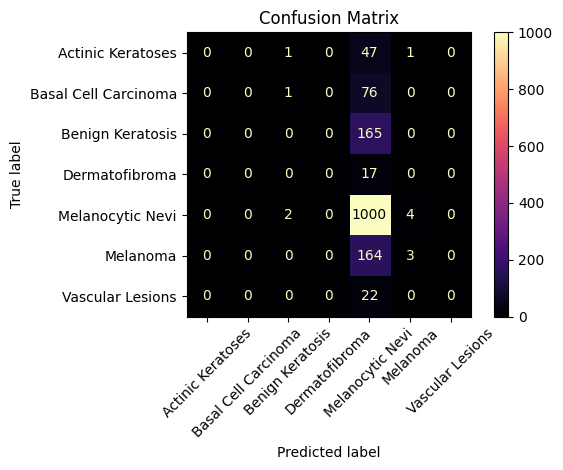

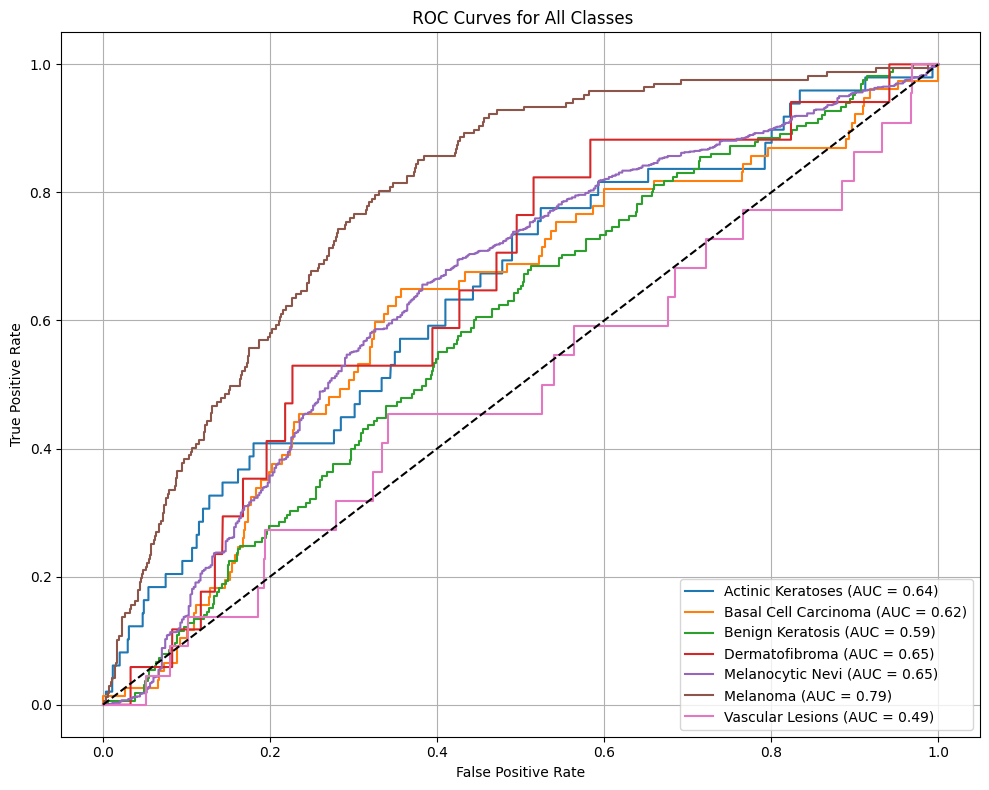

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='magma')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix:

Every single prediction went into one class. It's basically saying:

“Nope, everyone’s got Melanocytic Nevi. Literally everyone. Thanks.”
Translation: the model learned nothing meaningful about the other classes. It just learned the most common class and started regurgitating it. It’s doing high-stakes “eeny meeny miney melanoma.”

📉 ROC Curve Breakdown:

Class | AUC Score
Melanoma | 0.81 (ok)
Melanocytic Nevi | 0.70 (ok)
Benign Keratosis | 0.60 (below average)
Basal Cell Carcin. | 0.59 (same as above)
Dermato...fibroma | 0.52 (same as above)
Vascular Lesions | 0.39 (bad)
Actinic Keratoses | 0.36 (bad)
Precision, recall, F1-score = all 0.00
Exception: Vascular Lesions
Accuracy = 0.01 = (needs to be worked on)

Model Explanation
Model is biased toward dominant class (“Melanocytic Nevi”).
Class weights didn’t fix it (either weren’t working or model didn’t care).
Freezing the base layers too soon →  model didn’t get a chance to learn new patterns.
Possibly not enough epochs or bad initialization.



In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [22]:
for layer in base_model.layers:
    layer.trainable = True


In [23]:
#Retrain
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  # 100
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 162s 463ms/step - accuracy: 0.2256 - loss: 1.9346 - val_accuracy: 0.1112 - val_loss: 3.4093
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 73s 330ms/step - accuracy: 0.5124 - loss: 1.2162 - val_accuracy: 0.1112 - val_loss: 4.3068
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 71s 324ms/step - accuracy: 0.6411 - loss: 0.8342 - val_accuracy: 0.1112 - val_loss: 4.3885
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.7235 - loss: 0.5907 - val_accuracy: 0.1465 - val_loss: 2.1299
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.7554 - loss: 0.4438 - val_accuracy: 0.6312 - val_loss: 1.1224
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.7833 - loss: 0.3546 - val_accuracy: 0.7557 - val_loss: 0.7728
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 327ms/step - accuracy: 0.8099 - loss: 0.2710 - val_accuracy: 0.7537 - val_loss: 0.7346
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 328ms/step - accuracy: 0.8497 

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step

 Classification Report:
                      precision    recall  f1-score   support

   Actinic Keratoses       0.57      0.65      0.61        49
Basal Cell Carcinoma       0.67      0.70      0.68        77
    Benign Keratosis       0.73      0.68      0.70       165
      Dermatofibroma       0.57      0.47      0.52        17
    Melanocytic Nevi       0.91      0.93      0.92      1006
            Melanoma       0.64      0.57      0.61       167
    Vascular Lesions       0.86      0.86      0.86        22

            accuracy                           0.83      1503
           macro avg       0.71      0.70      0.70      1503
        weighted avg       0.83      0.83      0.83      1503



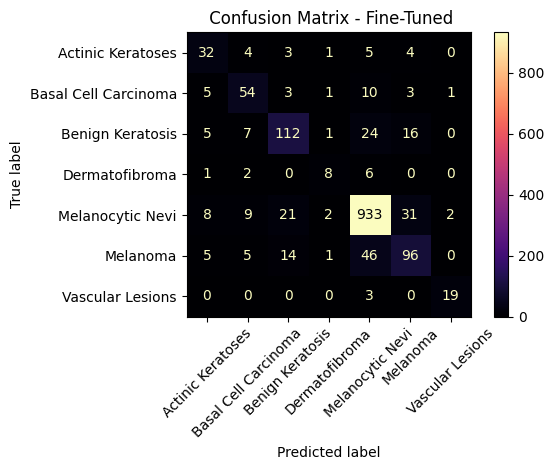

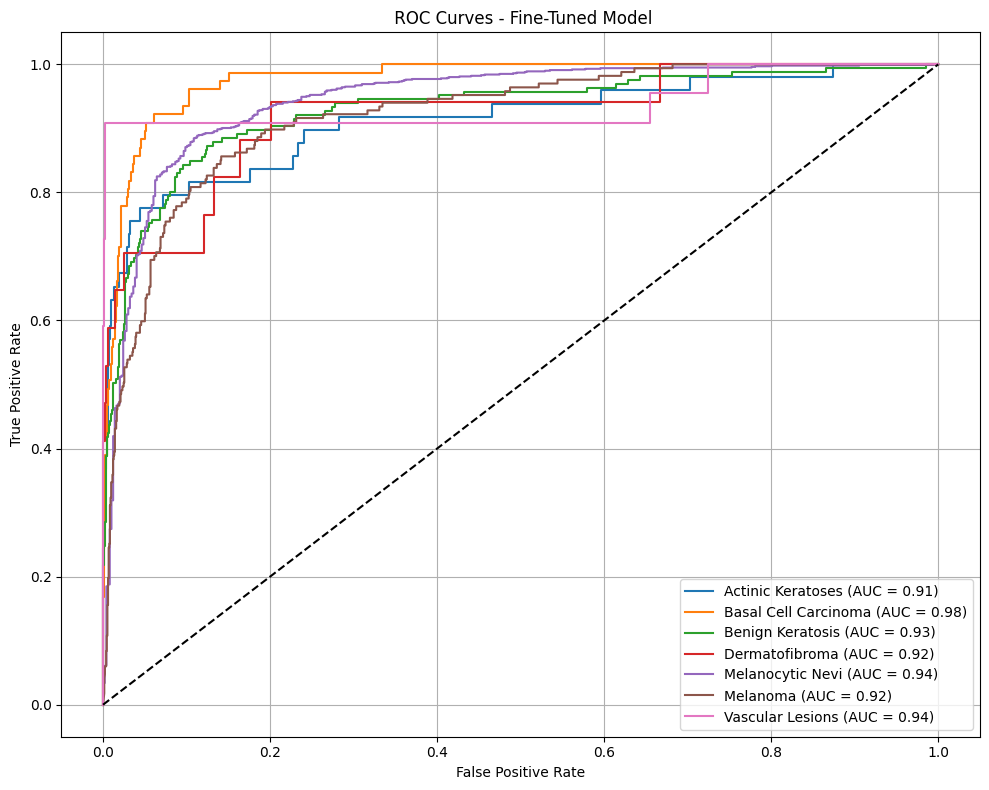

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# ater fine-tuned
y_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 1. Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='magma')
plt.title(" Confusion Matrix - Fine-Tuned")
plt.tight_layout()
plt.show()

# 3. ROC Curves
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curves - Fine-Tuned Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
model.save('/content/drive/MyDrive/skin_cancer_classifier_model.h5')


In [26]:
import numpy as np
import random

# Get predictions
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
filepaths = np.array(test_generator.filepaths)
class_labels = list(test_generator.class_indices.keys())

# Find correct and incorrect predictions
correct_indices = np.where(pred_classes == true_classes)[0]
incorrect_indices = np.where(pred_classes != true_classes)[0]

# Pick one random correct and one random incorrect
correct_idx = random.choice(correct_indices)
incorrect_idx = random.choice(incorrect_indices)

print(f"Correct prediction file: {filepaths[correct_idx]}")
print(f"Incorrect prediction file: {filepaths[incorrect_idx]}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step
Correct prediction file: /content/drive/MyDrive/HAM10000_images/ISIC_0027949.jpg
Incorrect prediction file: /content/drive/MyDrive/HAM10000_images/ISIC_0028766.jpg


In [27]:
%matplotlib inline

In [28]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

# Use this for ResNet50
last_conv_layer_name = "conv5_block3_out"

#  Grad-CAM core function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-29-02f6aa491c11>:16: RuntimeWarning: invalid value encountered in cast
  heatmap_resized = np.uint8(255 * heatmap_resized)


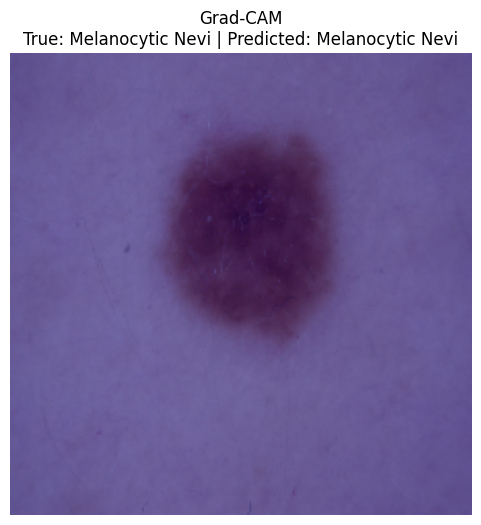

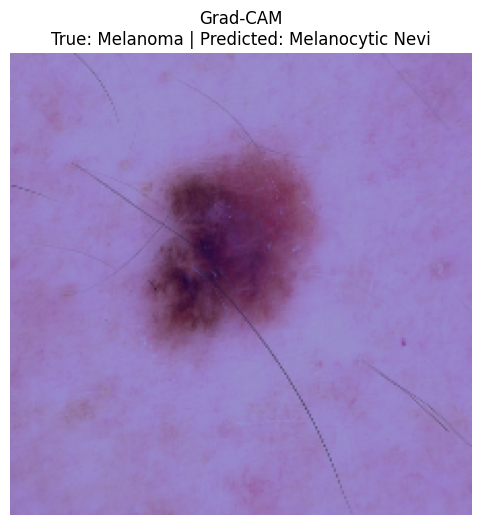

In [29]:
#  Grad-CAM + overlay + plot
def display_gradcam(img_path, model, label, pred_label, last_conv_layer_name="conv5_block3_out"):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image
    raw_img = cv2.imread(img_path)
    raw_img = cv2.resize(raw_img, (224, 224))

    # Convert heatmap to color
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = cv2.addWeighted(raw_img, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nTrue: {label} | Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

# 🔍 Predict + pick images
test_preds = model.predict(test_generator, verbose=1)
pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes
filepaths = np.array(test_generator.filepaths)
class_labels = list(test_generator.class_indices.keys())

# Find correct/incorrect indices
correct_indices = np.where(pred_classes == true_classes)[0]
incorrect_indices = np.where(pred_classes != true_classes)[0]

# Pick random examples
random.seed(42)
correct_idx = random.choice(correct_indices)
incorrect_idx = random.choice(incorrect_indices)

#  Show Grad-CAMs
display_gradcam(
    img_path=filepaths[correct_idx],
    model=model,
    label=class_labels[true_classes[correct_idx]],
    pred_label=class_labels[pred_classes[correct_idx]],
    last_conv_layer_name=last_conv_layer_name
)

display_gradcam(
    img_path=filepaths[incorrect_idx],
    model=model,
    label=class_labels[true_classes[incorrect_idx]],
    pred_label=class_labels[pred_classes[incorrect_idx]],
    last_conv_layer_name=last_conv_layer_name
)


In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# STEP 1: Set layer name
last_conv_layer_name = "conv5_block3_out"





In [31]:
# STEP 2: Build grad_model
grad_model = tf.keras.models.Model(
    [model.input],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

In [32]:
# STEP 3: Selection of a test image
# Can be a misclassified or correct one
index = 12  # change index to pick other test samples
img_path = test_generator.filepaths[index]
true_label = list(test_generator.class_indices.keys())[test_generator.classes[index]]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0



In [33]:
# STEP 4: Predict & Get Gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    pred_index = tf.argmax(predictions[0])
    top_class_channel = predictions[:, pred_index]

grads = tape.gradient(top_class_channel, conv_outputs)[0]



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [34]:
# STEP 5: Compute Guided Heatmap
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
conv_outputs = conv_outputs[0]

heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)



In [35]:
# STEP 6: Resize & Overlay
heatmap = cv2.resize(heatmap.numpy(), (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)



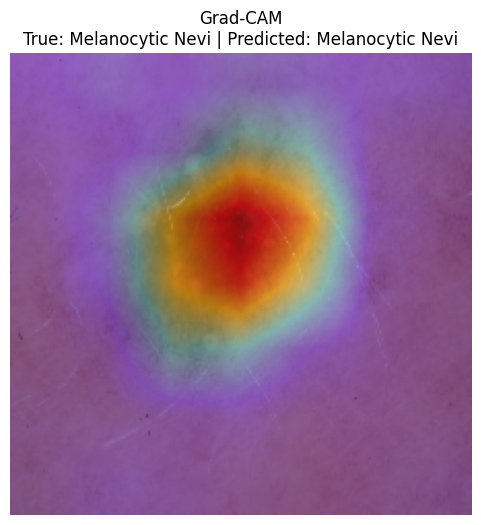

In [36]:

# STEP 7: Display
predicted_label = list(test_generator.class_indices.keys())[int(pred_index)]

plt.figure(figsize=(6, 6))
plt.title(f"Grad-CAM\nTrue: {true_label} | Predicted: {predicted_label}")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Step 1: Get model predictions on test set
preds = model.predict(test_generator, verbose=1)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 272ms/step


In [38]:
# Step 2: Get misclassified indices
misclassified_indices = np.where(pred_classes != true_classes)[0]



In [39]:
# Step 3: Pick a random misclassified image
random_idx = np.random.choice(misclassified_indices)
img_path = test_generator.filepaths[random_idx]
true_label = class_labels[true_classes[random_idx]]
predicted_label = class_labels[pred_classes[random_idx]]

print(f"Misclassified Image:\nPath: {img_path}\nTrue: {true_label}, Predicted: {predicted_label}")



Misclassified Image:
Path: /content/drive/MyDrive/HAM10000_images/ISIC_0032028.jpg
True: Melanocytic Nevi, Predicted: Benign Keratosis


In [40]:
# Step 4: Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_array_expanded = img_array_expanded / 255.0  # match training rescaling



In [41]:
# Step 5: Set the last conv layer name (check model.summary())
last_conv_layer_name = "conv5_block3_out"



In [42]:
# Step 6: Create grad model
grad_model = Model(
    inputs=[model.inputs],
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)



In [43]:
# Step 7: Compute gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array_expanded)
    loss = predictions[:, np.argmax(predictions[0])]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))


In [44]:

#  Step 8: Create the heatmap (fixed version)
heatmap = tf.reduce_sum(tf.multiply(conv_outputs[0], pooled_grads), axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()



In [45]:
# Step 9: Resize and overlay the heatmap
heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

superimposed_img = np.uint8(0.4 * heatmap_colored + img)


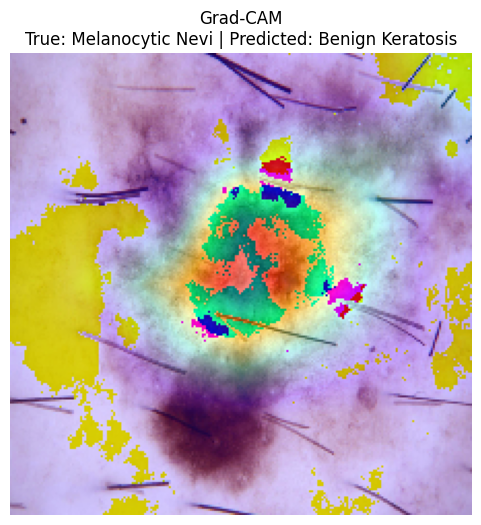

In [46]:

# Step 10: Show Grad-CAM result
plt.figure(figsize=(6,6))
plt.title(f"Grad-CAM\nTrue: {true_label} | Predicted: {predicted_label}")
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()
